# Classifier Notebook
### Questions

### Useful links

## Load rawcounts and normalized_logcounts

In [8]:
import scanpy as sc

from warnings import filterwarnings
filterwarnings('ignore')

adata = sc.read_h5ad('../sc_training.h5ad')
adata.layers['normalized_logcounts'] = adata.X.copy()
adata.X = adata.layers['rawcounts'].copy()  

sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)


In [9]:
normdf = adata.to_df(layer="normalized_logcounts")

In [10]:
normdf.head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGCAACGGT-1,0.484165,0.484165,0.808991,0.0,0.0,0.0,0.000000,0.0,0.484165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTACGACG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.693748,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTCGTTTG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGAAGAG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
adata.obs['state'] #labels

053l1_AAACCTGAGATGTCGG-1    terminal exhausted
053l1_AAACCTGAGCAACGGT-1              effector
053l1_AAACCTGAGTACGACG-1              effector
053l1_AAACCTGAGTCGTTTG-1    terminal exhausted
053l1_AAACCTGAGTGAAGAG-1              effector
                                   ...        
053l4_TTTGTCATCAGGTTCA-1                 other
053l4_TTTGTCATCAGTGTTG-1               cycling
053l4_TTTGTCATCCTCGCAT-1               cycling
053l4_TTTGTCATCTTCAACT-1               cycling
053l4_TTTGTCATCTTTCCTC-1               cycling
Name: state, Length: 28697, dtype: category
Categories (5, object): ['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted']

## Models
- consider putting this in a Pipeline with the variance filter as a custom Transformer: https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd

In [6]:
X = normdf
y = adata.obs['state']

## Filter out low variance genes (see EDA)

In [7]:
var_per_gene = normdf.var(axis = 0)

In [8]:
filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]

In [9]:
X = normdf.filter(filt.index.values, axis = 1)

In [10]:
def filter(normdf):
    var_per_gene = normdf.var(axis = 0)
    filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]
    X = normdf.filter(filt.index.values, axis = 1)
    return X

## Separate samples by perturbation class

In [12]:
df_cond = pd.DataFrame(adata.obs['condition'])
unpert_sample_in = df_cond[df_cond['condition'] == 'Unperturbed'].index

In [13]:
df_unpert = normdf.filter(unpert_sample_in, axis = 0)
df_unpert.head() 

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.0,0.0,0.292065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_unpert_labels = y.filter(unpert_sample_in, axis = 0)

In [15]:
filter(df_unpert).head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,Cops5,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,CAAA01147332.1,AC149090.1
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.610826,1.099769,0.000000,0.000000,1.736030,0.000000,0.0,0.000000,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.686024,1.375591,0.686024,0.000000,0.686024,1.779859,0.686024,0.0,0.000000,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.292065,0.0,0.0,0.517829,...,0.517829,2.135607,1.216197,1.479762,0.000000,2.284313,0.292065,0.0,0.292065,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,1.020401,0.000000,0.000000,1.844182,0.000000,0.0,1.020401,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,1.836899,2.187799,2.187799,0.000000,0.000000,2.187799,0.000000,0.0,0.000000,0.0


## SVM
- unperturbed cells data only

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt


In [81]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
svc = SVC(gamma = 1e-3, C = 100) #auto = 1/n_features, scale = 1/(n_features * variance(X))
svc.fit(X_train, y_train)


SVC(C=100, gamma=0.001)

In [82]:
svc.classes_

array(['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted'],
      dtype=object)

In [83]:
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

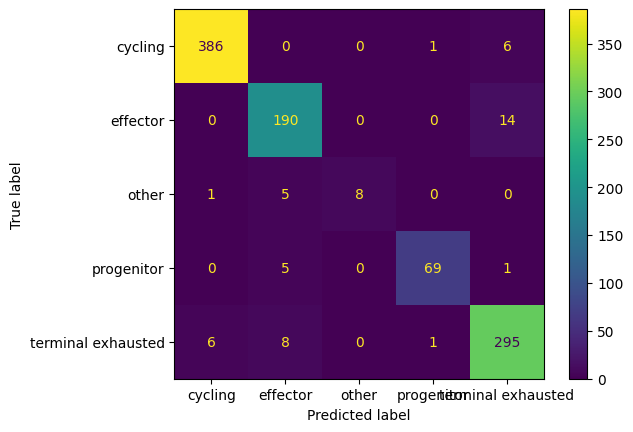

In [84]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

#plt.savefig('../graphs/cm_plot_svm.png')
plt.show()

In [85]:
print(svc.classes_)
f1_score(y_test, preds, average=None)


['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.9821883 , 0.9223301 , 0.72727273, 0.94520548, 0.94249201])

Are these the best hyperparameters? Check a wide range via GridSearch

In [24]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
parameters = {'kernel':['rbf'], 'C':[1e-1, 1, 1e2, 1e3], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2]}
#parameters = {'kernel':['rbf'], 'C':[1e-1, 1], 'gamma': [1e-3]}
svc = SVC()
clf = GridSearchCV(estimator = svc, param_grid = parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 100.0],
                         'kernel': ['rbf']},
             verbose=3)

In [86]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [41]:
clf.best_estimator_

SVC(C=100.0, gamma=0.0001)

In [ ]:
cv = pd.DataFrame(clf.cv_results_)
cv.to_csv('svm_gridsearch_results.csv')

## SVM
- try with all cells

In [11]:
X_train, X_test, y_train, y_test = train_test_split(normdf, adata.obs['state'], test_size=.2, random_state=88)
#svc = SVC(gamma = 'auto', C = 1, verbose = 3) #auto = 1/n_features, scale = 1/(n_features * variance(X))
#svc.fit(X_train, y_train)

### save all cells svm model, which takes a long time to train

In [1]:
import pickle
filename = 'svc_model_allcells.sav'
pickle.dump(svc, open(filename, 'wb'))

NameError: name 'svc' is not defined

In [12]:
#load model for use
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test[0:10], y_test[0:10])
print(result)

0.9


In [10]:
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

plt.savefig('../graphs/cm_plot_svm_all.png')
plt.show()

KeyboardInterrupt: 

In [9]:
print(svc.classes_)
f1_score(y_test, preds, average=None)

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.98119312, 0.92720307, 0.72222222, 0.96641387, 0.94868239])

Ideas for next steps 1/22/23:
- grid search with the full data set to find optimal C and gamma
- ideas for speeding up the model? use random subset of the data?
- eda exploration of "other" category
    - heatmap suggests that misclassification of effector and other should be expected, since those categories are the most closely related when looking at the expression values of cells in those categories
- consider 1 page write up, check misclassified cells
- check how paper did preprocessing for t cell categorization

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(normdf, adata.obs['state'], test_size=.2, random_state=88)
parameters = {'kernel':['rbf'], 'C':[1, 1e2, 1e3], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]}

svc = SVC()
clf = GridSearchCV(estimator = svc, param_grid = parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)

clf.best_estimator_

cv = pd.DataFrame(clf.cv_results_)
cv.to_csv('svm_gridsearch_results_allcells.csv')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


## XGBoost

Already tried:
- filtering genes out by variance didn't improve the accuracy much (~42%)
- increasing estimator number didn't improve accuracy much (50 -> 100 ~42%)
- train on unperturbed data only: accuracy worse lol (39%), maybe bc less data?

In [99]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)

In [100]:
bst = XGBClassifier(n_estimators=100, max_depth=0, learning_rate=0.2, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

[21:23:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [101]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.46%


In [ ]:
>>> from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})